In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [7]:
df = pd.read_csv('aa.csv', sep=',', encoding = 'euc-kr')
df = df.drop('Silver($)',axis = 1)
df

,date,Gold,Silver,Dow,Nas,S&P,CNY,EUR,JPY,USD
0,20200731,75628.90,926.271641,26428.32,10745.28,3271.12,170.67,1410.74,1137.32,1191.0
1,20200730,75110.59,897.475847,26313.65,10587.81,3246.22,170.68,1404.82,1138.13,1196.0
2,20200729,75110.45,932.827495,26539.57,10542.94,3258.44,170.56,1401.40,1137.09,1194.0
3,20200728,74342.85,935.967496,26379.28,10402.09,3218.44,171.27,1407.61,1140.26,1199.5
4,20200727,74332.14,942.098478,26584.77,10536.27,3239.41,170.88,1403.60,1136.81,1197.0
...,...,...,...,...,...,...,...,...,...,...
2597,20100806,44660.81,690.243220,10653.56,2288.47,1121.64,171.75,1534.00,1350.28,1163.0
2598,20100805,44870.25,685.811886,10674.98,2293.06,1125.81,172.02,1531.28,1349.94,1165.0
2599,20100804,45009.08,686.874468,10680.43,2303.57,1127.24,172.74,1543.23,1368.42,1170.0
2600,20100803,44425.74,691.629077,10636.38,2283.52,1120.46,172.49,1545.93,1359.20,1168.5


In [8]:
# Train Test Split 개수
TRAIN_SPLIT = 2000
tf.random.set_seed(2020)

In [9]:
BATCH_SIZE = 512
BUFFER_SIZE = 10000

In [10]:
EVALUATION_INTERVAL = 200
# EPOCHS 횟수
EPOCHS = 30

# Multivariate 시계열 예측

In [11]:
# EUR 제거
features_considered = ['Gold','Silver','Dow','Nas','S&P','CNY','JPY','USD']

In [12]:
features = df[features_considered]
features.index = df['date']
features

,Gold,Silver,Dow,Nas,S&P,CNY,JPY,USD
date,,,,,,,,
20200731,75628.90,926.271641,26428.32,10745.28,3271.12,170.67,1137.32,1191.0
20200730,75110.59,897.475847,26313.65,10587.81,3246.22,170.68,1138.13,1196.0
20200729,75110.45,932.827495,26539.57,10542.94,3258.44,170.56,1137.09,1194.0
20200728,74342.85,935.967496,26379.28,10402.09,3218.44,171.27,1140.26,1199.5
20200727,74332.14,942.098478,26584.77,10536.27,3239.41,170.88,1136.81,1197.0
...,...,...,...,...,...,...,...,...
20100806,44660.81,690.243220,10653.56,2288.47,1121.64,171.75,1350.28,1163.0
20100805,44870.25,685.811886,10674.98,2293.06,1125.81,172.02,1349.94,1165.0
20100804,45009.08,686.874468,10680.43,2303.57,1127.24,172.74,1368.42,1170.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000154A3C07F48>,
      dtype=object)

<Figure size 1080x648 with 0 Axes>

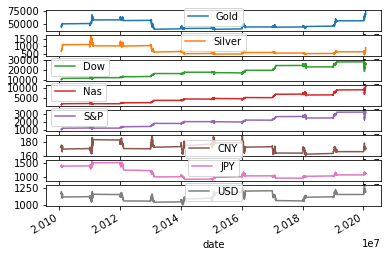

In [13]:
plt.figure(figsize=(15, 9))
features.plot(subplots= True)

In [14]:
# 데이터 표준화
dataset = features.values
data_mean = dataset.mean(axis = 0)
data_std = dataset.std(axis=0)
dataset = (dataset - data_mean)/data_std

In [15]:
def multivariate_data(dataset, target, start_index, end_index,
                     history_size, target_size, step, single_step = False):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)-target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i , step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
            
    return np.array(data), np.array(labels)

In [16]:
past_history = 120
STEP = 5

In [17]:
future_target = 64

x_train_multi, y_train_multi = multivariate_data(dataset,dataset[:,3], 0 ,
                                                  TRAIN_SPLIT, past_history,
                                                  future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset,dataset[:,3],
                                                  TRAIN_SPLIT, None, past_history,
                                                  future_target, STEP)

In [18]:
print('Single window of past history : {}'.format(x_train_multi[0].shape))
print('\nTarget Price to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (24, 8)

Target Price to predict : (64,)


In [19]:
x_train_multi.shape

(1880, 24, 8)

In [20]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi,y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi,y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [21]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize = (12,6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.plot(num_in, np.array(history[:,1]), label= "HISTORY")
    plt.plot(np.arange(num_out)/STEP, np.array(true_future),'bo',
            label = 'True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),'ro',
                label = 'Prediction Future')
        
    plt.legend(loc='upper left')
    plt.show()

In [22]:
def create_time_steps(length):
    return list(range(-length, 0))

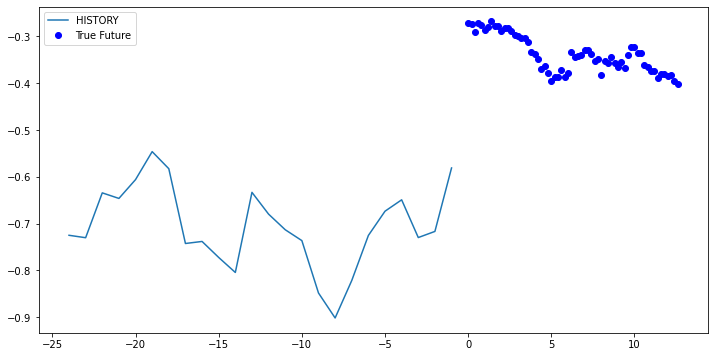

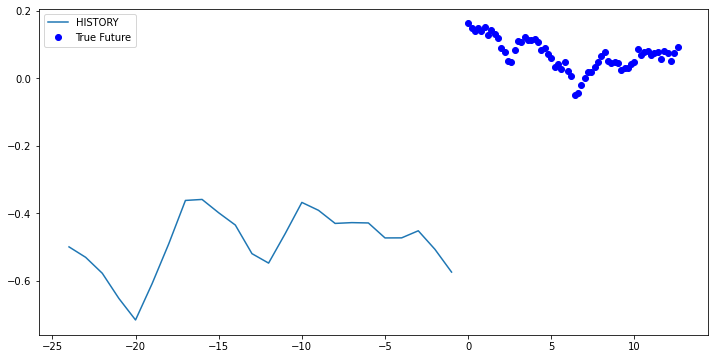

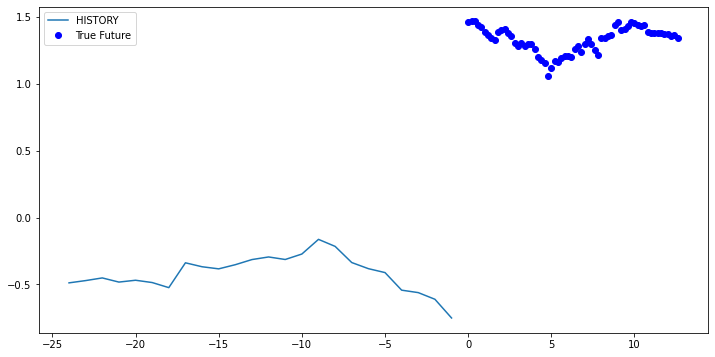

In [23]:
for x, y in train_data_multi.take(3):
    multi_step_plot(x[0],y[0],np.array([0]))

In [29]:
# Model 생성
multi_step_model = Sequential()
multi_step_model.add(LSTM(32, return_sequences=True,
                         input_shape = x_train_multi.shape[-2:]))
multi_step_model.add(LSTM(16,activation = 'relu'))
multi_step_model.add(Dense(64))

multi_step_model.compile(optimizer = RMSprop(clipvalue = 1.0), loss = 'mae')

In [30]:
for x , y in val_data_multi.take(1):
    print(multi_step_model.predict(x).shape)

(418, 64)


In [31]:
modelpath="./model/future.hdf5"
checkpointer=ModelCheckpoint(filepath=modelpath,monitor="val_loss",
                            verbose=2, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30)

In [32]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs = EPOCHS,
                                         steps_per_epoch = EVALUATION_INTERVAL,
                                         validation_data = val_data_multi,
                                         validation_steps = 50, callbacks = [checkpointer,early_stopping_callback])

Train for 200 steps, validate for 50 steps
Epoch 1/30
198/200 [============================>.] - ETA: 0s - loss: 0.2162
Epoch 00001: val_loss improved from inf to 0.45410, saving model to ./model/future.hdf5
200/200 [==============================] - 9s 43ms/step - loss: 0.2150 - val_loss: 0.4541
Epoch 2/30
198/200 [============================>.] - ETA: 0s - loss: 0.0786
Epoch 00002: val_loss improved from 0.45410 to 0.32623, saving model to ./model/future.hdf5
200/200 [==============================] - 7s 34ms/step - loss: 0.0785 - val_loss: 0.3262
Epoch 3/30
198/200 [============================>.] - ETA: 0s - loss: 0.0671
Epoch 00003: val_loss improved from 0.32623 to 0.32039, saving model to ./model/future.hdf5
200/200 [==============================] - 6s 32ms/step - loss: 0.0670 - val_loss: 0.3204
Epoch 4/30
199/200 [============================>.] - ETA: 0s - loss: 0.0609
Epoch 00004: val_loss improved from 0.32039 to 0.28964, saving model to ./model/future.hdf5
200/200 [======

In [33]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

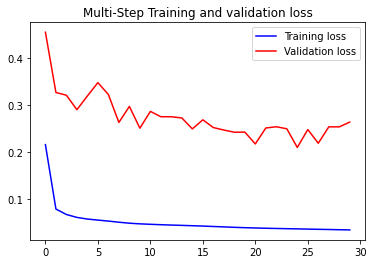

In [34]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [35]:
# del multi_step_model
# multi_step_model = load_model("./model/future.hdf5")

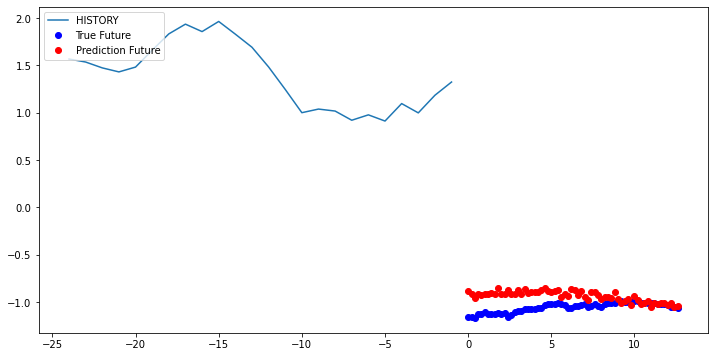

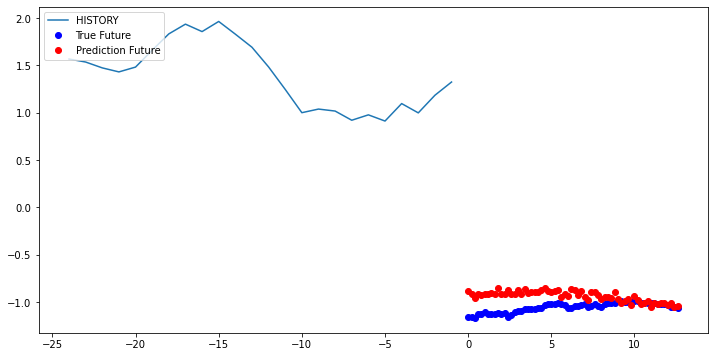

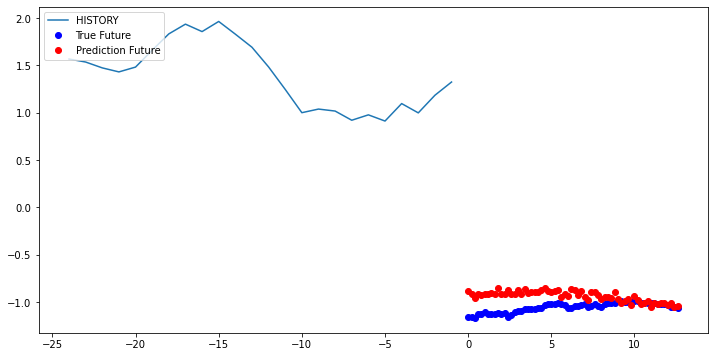

In [36]:
for x , y in val_data_multi.take(3):
    multi_step_plot(x[0],y[0],multi_step_model.predict(x)[0])